In [58]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import re
from multiprocessing import Queue
import networkx as nx
import musicbrainzngs as mb 

CLIENT_ID = "3a533c6fd3434a29a09896712d5c19bd"
CLIENT_SECRET = "65f9ad113dd54f6091cee7aa5498568b"
mb.set_useragent('redes_complejas', 0.1) 

def conseguir_id(artista):
    # POST donde le pasamos las clave de la app
    response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': CLIENT_ID, 'client_secret': CLIENT_SECRET})
    # Guardamos el bearer token para usarlo en las peticiones de la API
    access_token = response.json()['access_token']
    headers = {'Authorization': 'Bearer {}'.format(access_token), 'Accept': 'application/json', 'Content-Type': 'application/json'}

    """
    Recibe
        artista: Nombre del artista del cual se quiere su ID
    Devuelve:
        id: La ID del artista
    """
    # End point para obtener los audio features. Esto se saca de la referencia de la documentación
    url = 'https://api.spotify.com/v1/search'

    # Búsqueda. Acá sí hay que pasarselo como parámetros
    params = {'q': f"{artista}", 'type': 'artist', 'limit': '2'}

    # En este caso no lleva ningún parámetro, el id de la canción va directamente en el url
    response = requests.get(url, params = params, headers = headers)

    # Vemos el json de la respuesta
    json_data = response.json()
    
    # Con la siguiente lista conseguimos el ID del primer resultado de la busqueda (creo)
    id = json_data["artists"]["items"][0]["id"]

    return id

def es_argentino(nombre_artista): #devuelve true or false nada mas, si queremos mas cosas cambiarlo
    # Metemos a Argentina en la lista de provincias por las dudas ya que hay artistas que lo tienen
    es_arg = False
    lista_provincias = ["Argentina","Buenos Aires", "Catamarca", "Chaco", "Chubut", "Córdoba", "Corrientes", "Entre Ríos", "Formosa", "Jujuy", "La Pampa", "La Rioja", "Mendoza", "Misiones", "Neuquén", "Río Negro", "Salta", "San Juan", "San Luis", "Santa Cruz", "Santa Fe", "Santiago del Estero", "Tierra del Fuego", "Tucumán"]
    data = mb.search_artists(artist = nombre_artista, limit= 1)
    if data["artist-count"] != 0: #SI ENCUENTRA EL ARTISTA EN MUSIC BRANDZ
        if "country" in data["artist-list"][0]:
            pais = data["artist-list"][0]["country"]
            if pais == 'AR':
                es_arg = True
        # Comprobamos las provincias si no está el país
        elif "begin-area" in data["artist-list"][0]:
            provincia = data["artist-list"][0]["begin-area"]["name"]
            if provincia in lista_provincias:
                es_arg = True
        elif "area" in data["artist-list"][0]:
            provincia = data["artist-list"][0]["area"]["name"]
            if provincia in lista_provincias:
                es_arg = True
    return es_arg


# Ambas formas de cargar el uri sirven
uri = 'spotify:artist:7ltDVBr6mKbRvohxheJ9h1'
uri = "3vQ0GE3mI0dAaxIMYe5g7z"
# En la siguiente línea se define de donde se saca toda la info, como si este fuera el paquete
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = CLIENT_ID, client_secret=CLIENT_SECRET))

q = Queue()

def red_colaboradores_artista(nombre_artista, G):
    lista_cuadrivectores = []
    albums_revisados = []
    lista_colaboradores = []
    # Uri es como el id del artista pero para spotipy
    uri = "spotify:artist:" + conseguir_id(nombre_artista)
    # Conseguimos los albumes del artista
    results = sp.artist_albums(uri, album_type='album,single', country='AR')
    albums = results['items']

    # No se que hace bien todavia 
    while results['next']:
        # Depaginate
        results = sp.next(results)
        albums.extend(results['items'])

    # Hacemos un filtro a los albumes para que sean únicos
    real_albums = dict()
    for album in albums:
        # Strip extraneous characters
        name = re.sub(r'\([^)]*\)|\[[^)]*\]', '', album['name']) # remove (Deluxe edition) and [Feat. asdf] tags
        name = re.sub(r'\W','', name).lower().strip() # remove all non-alphanumerical characters
        if name not in real_albums:
            # print('Adding ' + name)
            real_albums[name] = album

    # Ciclamos sobre los albumes que son únicos
    for album in real_albums:
        # Chequeamos que no hayamos revisado el album
        if album not in albums_revisados:
            # Mark album as analyzed
            albums_revisados.append(album)
            # print('\tAlbum: ' + real_albums[album]['name'])

            # Obtenemos las canciones del album
            results = sp.album_tracks(real_albums[album]['id'])
            canciones = results['items']
            while results['next']:
                results = sp.next(results)
                canciones.extend(results['items'])

            # Recorremos las canciones
            for cancion in canciones:
                # Recorremos los artistas de la canción
                for artist in cancion['artists']:
                    # Chequeamos que no tengan igual uri
                    if artist['uri'] != uri:
                        # print('\t\t' + artist['name'])
                        # La siguiente línea no la entiendo bien, pero creo que lo que hace es el time.sleep que haciamos pero mejor
                        q.put(artist['uri'])

                        if artist['uri'] not in G and es_argentino(artist['name']):
                            # Get detailed description of artist and create node
                            artist = sp.artist(artist['uri'])
                                # print(artist)
                            G.add_node(artist['name'], id=artist['uri'], popularidad=artist['popularity'], generos = artist['genres'])
                            lista_colaboradores.append(artist['name'])
                            # # Try adding artist's image
                            # if len(artist['images']) > 0:
                            #     G.node[artist['uri']]['image_url'] = artist['images'][0]['url']
                            # else:
                            #     G.node[artist['uri']]['image_url'] = "https://developer.spotify.com/wp-content/uploads/2016/07/icon1@2x.png"
                        # Count how many collaborations
                            try:
                                G[artist['name']][nombre_artista]['freq'] += 1
                            except KeyError:
                                G.add_edge(artist['name'], nombre_artista, freq=1)
    return lista_colaboradores

def crear_red_ego(nombre_artista):
    G = nx.Graph()
    lista_colaboradores = red_colaboradores_artista(nombre_artista, G)
    # for colaborador in lista_colaboradores:
    #     lista_colaborades_2 = red_colaboradores_artista(colaborador, G)
    #     for colaborador_2 in lista_colaboradores_2:
    #         if colaborador_2 not in lista_colaboradores:
    #             lista_colaboradores.append(colaborador_2)
        
    return G


        

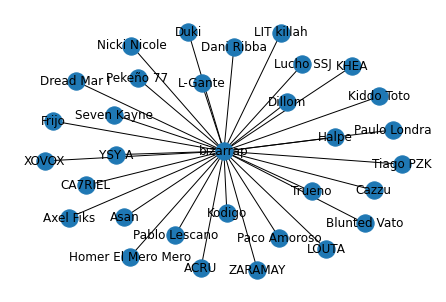

In [59]:
red = crear_red_ego('bizarrap')
nx.draw(red, with_labels = True)